<a href="https://colab.research.google.com/github/poomshift/remove-bg-colab/blob/main/alchemist_removeBG_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

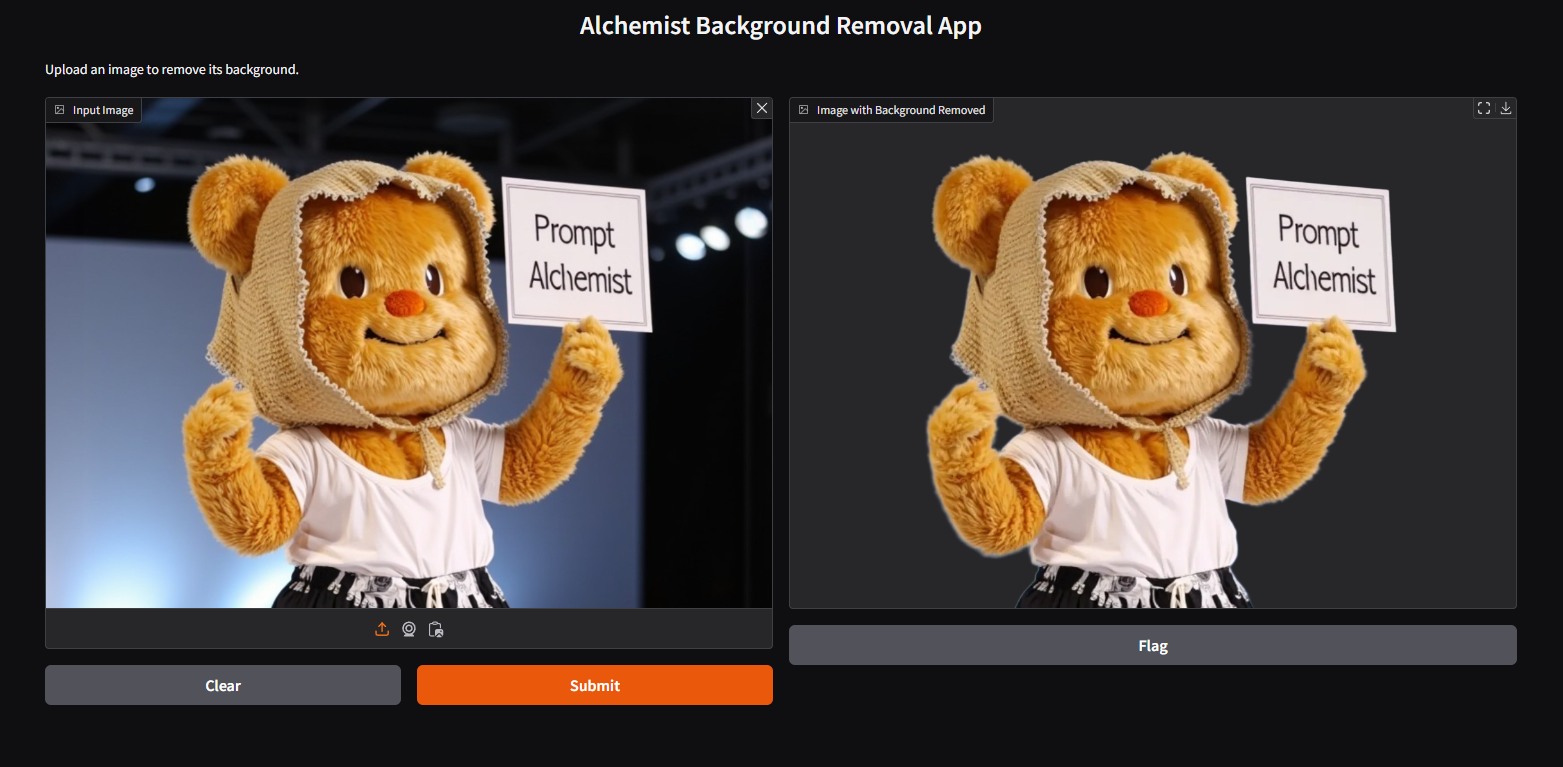

ติดต่อสอบถาม https://www.facebook.com/PromptAlchemist

In [ ]:
#@markdown # 1. ติดตั้ง Dependencies ก่อน
from IPython.display import clear_output
from IPython.display import Javascript
import ipywidgets as widgets
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
def inf(msg, style, wdth): inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)
# Downloading all codes & dependencies
!git clone https://github.com/ZhengPeng7/BiRefNet.git
!pip uninstall -q torchaudio torchdata torchtext -y
!pip install -q -r BiRefNet/requirements.txt
!pip install -q -U gdown gradio timm==0.6.12

%cd BiRefNet

clear_output()
inf('\u2714 Done','success', '50px')

In [ ]:
#@markdown # 2. Run โปรแกรม

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 800})'''))
# Imports
from PIL import Image
import torch
from torchvision import transforms
import gradio as gr

# Modify the import to avoid the registry issue
import sys
sys.path.append('.')
from models.birefnet import BiRefNet

# Load Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision(['high', 'highest'][0])
model = BiRefNet.from_pretrained('zhengpeng7/birefnet')
model.to(device)
model.eval()
print('BiRefNet is ready to use.')

# Input Data
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def remove_background(image):
    w, h = image.size
    input_images = transform_image(image).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        preds = model(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # Resize the prediction to match the original image size
    pred_resized = transforms.Resize((h, w))(pred.unsqueeze(0)).squeeze()

    # Create masked image
    pred_pil = transforms.ToPILImage()(pred_resized)
    image_masked = image.copy()
    image_masked.putalpha(pred_pil)

    return image_masked

# Gradio Interface
iface = gr.Interface(
    fn=remove_background,
    inputs=[
        gr.Image(type="pil", label="Input Image"),
    ],
    outputs=gr.Image(type="pil", label="Image with Background Removed", format="png"),
    title="Alchemist Background Removal App",
    description="Upload an image to remove its background.",
)

# Launch the app without showing the UI in the output
iface.launch(share=True, quiet=True)
print(f"Gradio app is running. To access it, use the public URL provided above.")

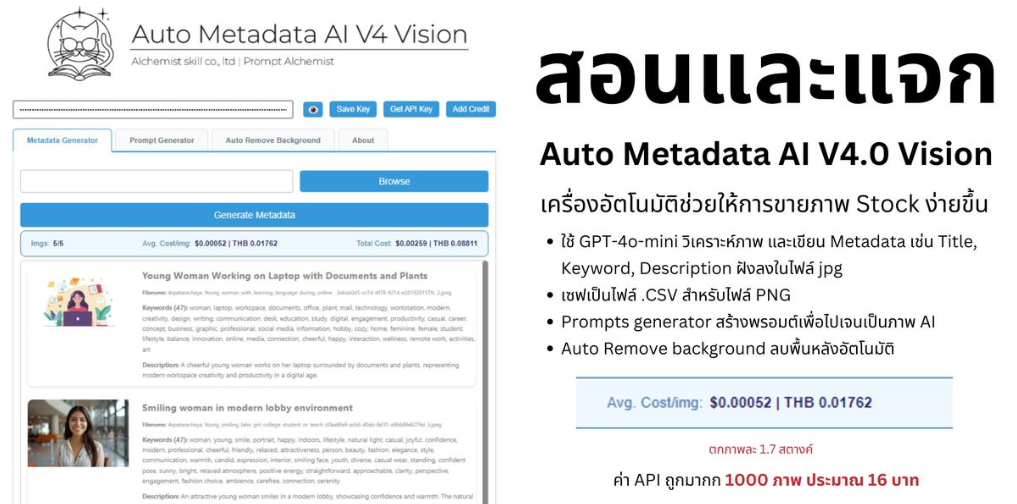

สอนใช้ Auto Metadata AI V4.0 Vision [>>คลิกที่นี่<<](https://www.facebook.com/PromptAlchemist/posts/pfbid0zuf6VGznXaJoiyJoxtztuvnCUMp2NHtPQ924vo4er2AZEF9MQLxg8DwmowuAY7MDl?locale=th_TH)